In [224]:
import nltk
#nltk.download()
from nltk import pos_tag, word_tokenize,sent_tokenize,corpus
from collections import Counter
from collections import defaultdict
from operator import itemgetter
from collections import OrderedDict
import numpy
import pandas
from matplotlib import *
from pylab import *
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet as wn
from gensim.models import word2vec,phrases
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
from nltk.corpus import PlaintextCorpusReader
#corpus_root=r"C:\Users\tihor\OneDrive\Documents\Python Scripts\TextParsing\FOMC"
corpus_root=r"C:\Users\tihor\Documents\TextParsing\FOMC"
fed=PlaintextCorpusReader(corpus_root, '.*')
len(fed.fileids())

49

In [179]:
def isNoun(tag):
    return tag in ['NN','NNS','NNP','NNPS']
    #if tag=="NN" or tag=="NNS" or tag=="NNP" or tag=="NNPS":
    #    return True
    #else:
    #    return False
def isAdjective(tag):
    return tag in ['JJ','JJR','JJS']
    #if tag=='JJ' or tag=='JJR' or tag=='JJS':
    #    return True
    #else:
    #    return False
def isVerb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def isAdverb(tag):
    return tag in ['RB', 'RBR', 'RBS']

def penn_to_wn(tag):
    if isAdjective(tag):
        return wn.ADJ
    elif isNoun(tag):
        return wn.NOUN
    elif isAdverb(tag):
        return wn.ADV
    elif isVerb(tag):
        return wn.VERB
    return None

In [180]:
def GetCollocations(text):
    collocations=[]
    tokens=word_tokenize(text)
    pos_tokens=pos_tag(tokens)
    for i in range(0,len(pos_tokens)):
        if isNoun(pos_tokens[i][1]) or isAdjective(pos_tokens[i][1]):
            if isNoun(pos_tokens[i+1][1]) or isAdjective(pos_tokens[i+1][1]):
                if isNoun(pos_tokens[i+2][1]):
                    if(isNoun(pos_tokens[i+3][1])):
                        collocations.append(pos_tokens[i][0]+" "+pos_tokens[i+1][0]+" "+pos_tokens[i+2][0]+" "+pos_tokens[i+3][0])
                    else:
                        collocations.append(pos_tokens[i][0]+" "+pos_tokens[i+1][0]+" "+pos_tokens[i+2][0])
                else:
                    collocations.append(pos_tokens[i][0]+" "+pos_tokens[i+1][0])
            elif pos_tokens[i+1][1]=='IN':
                if isNoun(pos_tokens[i+2][1]):
                    collocations.append(pos_tokens[i][0]+" "+pos_tokens[i+1][0]+" "+pos_tokens[i+2][0])
    return collocations

In [169]:
collocation_count=defaultdict(int)
for fileid in fed.fileids():
    collocations=GetCollocations(fed.raw(fileid))
    for item in collocations:
        collocation_count[item]=collocation_count.get(item,0)+1

In [170]:
sorted_count = OrderedDict(sorted(collocation_count.items(),key=lambda x:x[1],reverse=True))
sorted_count_no_duplicates=OrderedDict()
itemtoremove={}
for item1 in sorted_count:
    for item2 in sorted_count:
        if item1.find(item2)!=-1 and sorted_count[item1]==sorted_count[item2] and item1!=item2:
                itemtoremove[item2]=sorted_count[item2]
for item in sorted_count:
    if item not in itemtoremove.keys():
        sorted_count_no_duplicates[item]=sorted_count[item]

In [171]:
phrases=[]
for item in sorted_count_no_duplicates:
    if sorted_count_no_duplicates[item]>=len(fed.fileids()):
        print(item+"\t"+str(sorted_count_no_duplicates[item]))
        phrases.append(item.lower())

federal funds rate	177
maximum employment	135
agency mortgage-backed securities	122
inflation expectations	119
price stability	110
market conditions	109
target range	102
labor market conditions	97
labor market	85
economic activity	77
unemployment rate	73
dual mandate	71
Treasury securities	65
policy accommodation	57
longer-term inflation expectations	56
monetary policy	56
economic conditions	53
moderate pace	52
financial developments	51
holdings of agency	51
statutory mandate	49
Federal Open Market Committee	49
principal payments	49
Janet L. Yellen	49
William C. Dudley	49
Daniel K. Tarullo	49
Vice Chairman	49
FOMC monetary policy action	49


In [133]:
len(sorted_count_no_duplicates)

464

In [134]:
sentences=nltk.sent_tokenize(fed.raw('FOMCStatement-20140618.txt'))
tokenized_sentences=[nltk.word_tokenize(sentence) for sentence in sentences]
tagged_sentences=[nltk.pos_tag(sentence) for sentence in tokenized_sentences]
chunked_sentences=nltk.ne_chunk_sents(tagged_sentences,binary=True)

In [135]:
def extract_entity_names(t):
    entity_names=[]
    if hasattr(t,'label') and t.label:
        if t.label=='NE':
            entity_names.append(' '.join([child[0] for child in t]))
        else:
            for child in t:
                entity_names.extend(extract_entity_names(child))
    return entity_names

entity_names=[]
for tree in chunked_sentences:
    entity_names.extend(extract_entity_names(tree))

print(entity_names)

[]


In [172]:
def getPhraseCount(text,phrases):
    text=text.lower()
    count=[0 for phrase in phrases]
    pos=[0 for phrase in phrases]
    length=[len(phrase) for phrase in phrases]
    for phrase in phrases:
        list_index=phrases.index(phrase)
        while pos[list_index]<len(text):
            pos[list_index]=text.find(phrase,pos[list_index])
            if pos[list_index]>-1:
                count[list_index]=count[list_index]+1
                pos[list_index]=pos[list_index]+length[list_index]
            else:
                break
    return count

In [173]:
#phrases=['inflation','federal funds rate','maximum employment','agency mortgage-backed securities','price stability',
#         'inflation expectations','target range','labor market conditions','unemployment rate','economic activity',
#         'longer-term inflation expectations','dual mandate','economic recovery']
summary={}
for f in fed.fileids():
    rowName=f[f.find("-")+1:]
    rowName=rowName[:rowName.find(".txt")]
    summary[rowName]=getPhraseCount(fed.raw(f),phrases)
df=pandas.DataFrame(summary)
df=pandas.DataFrame(df.transpose())
df.columns=phrases
df

,federal funds rate,maximum employment,agency mortgage-backed securities,inflation expectations,price stability,market conditions,target range,labor market conditions,labor market,economic activity,...,financial developments,holdings of agency,statutory mandate,federal open market committee,principal payments,janet l. yellen,william c. dudley,daniel k. tarullo,vice chairman,fomc monetary policy action
20110126,2,2,0,2,3,1,1,1,1,0,...,1,0,1,1,1,1,1,1,1,1
20110315,2,2,0,3,3,0,1,0,1,0,...,1,0,1,1,1,1,1,1,1,1
20110427,2,2,0,3,3,0,1,0,1,0,...,1,0,1,1,1,1,1,1,1,1
20110622,2,2,0,2,2,0,1,0,1,0,...,1,0,1,1,1,1,1,1,1,1
20110809,3,1,0,2,2,1,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1
20110921,2,1,2,2,2,1,1,1,1,0,...,0,1,1,1,1,1,1,1,1,1
20111102,2,1,2,2,2,1,1,1,1,0,...,0,1,1,1,1,1,1,1,1,1
20111213,2,1,2,2,2,1,1,1,1,0,...,0,1,1,1,1,1,1,1,1,1
20120125,3,1,2,1,2,1,1,1,1,0,...,0,1,1,1,1,1,1,1,1,1
20120313,3,1,2,1,2,1,1,1,1,0,...,0,1,1,1,1,1,1,1,1,1


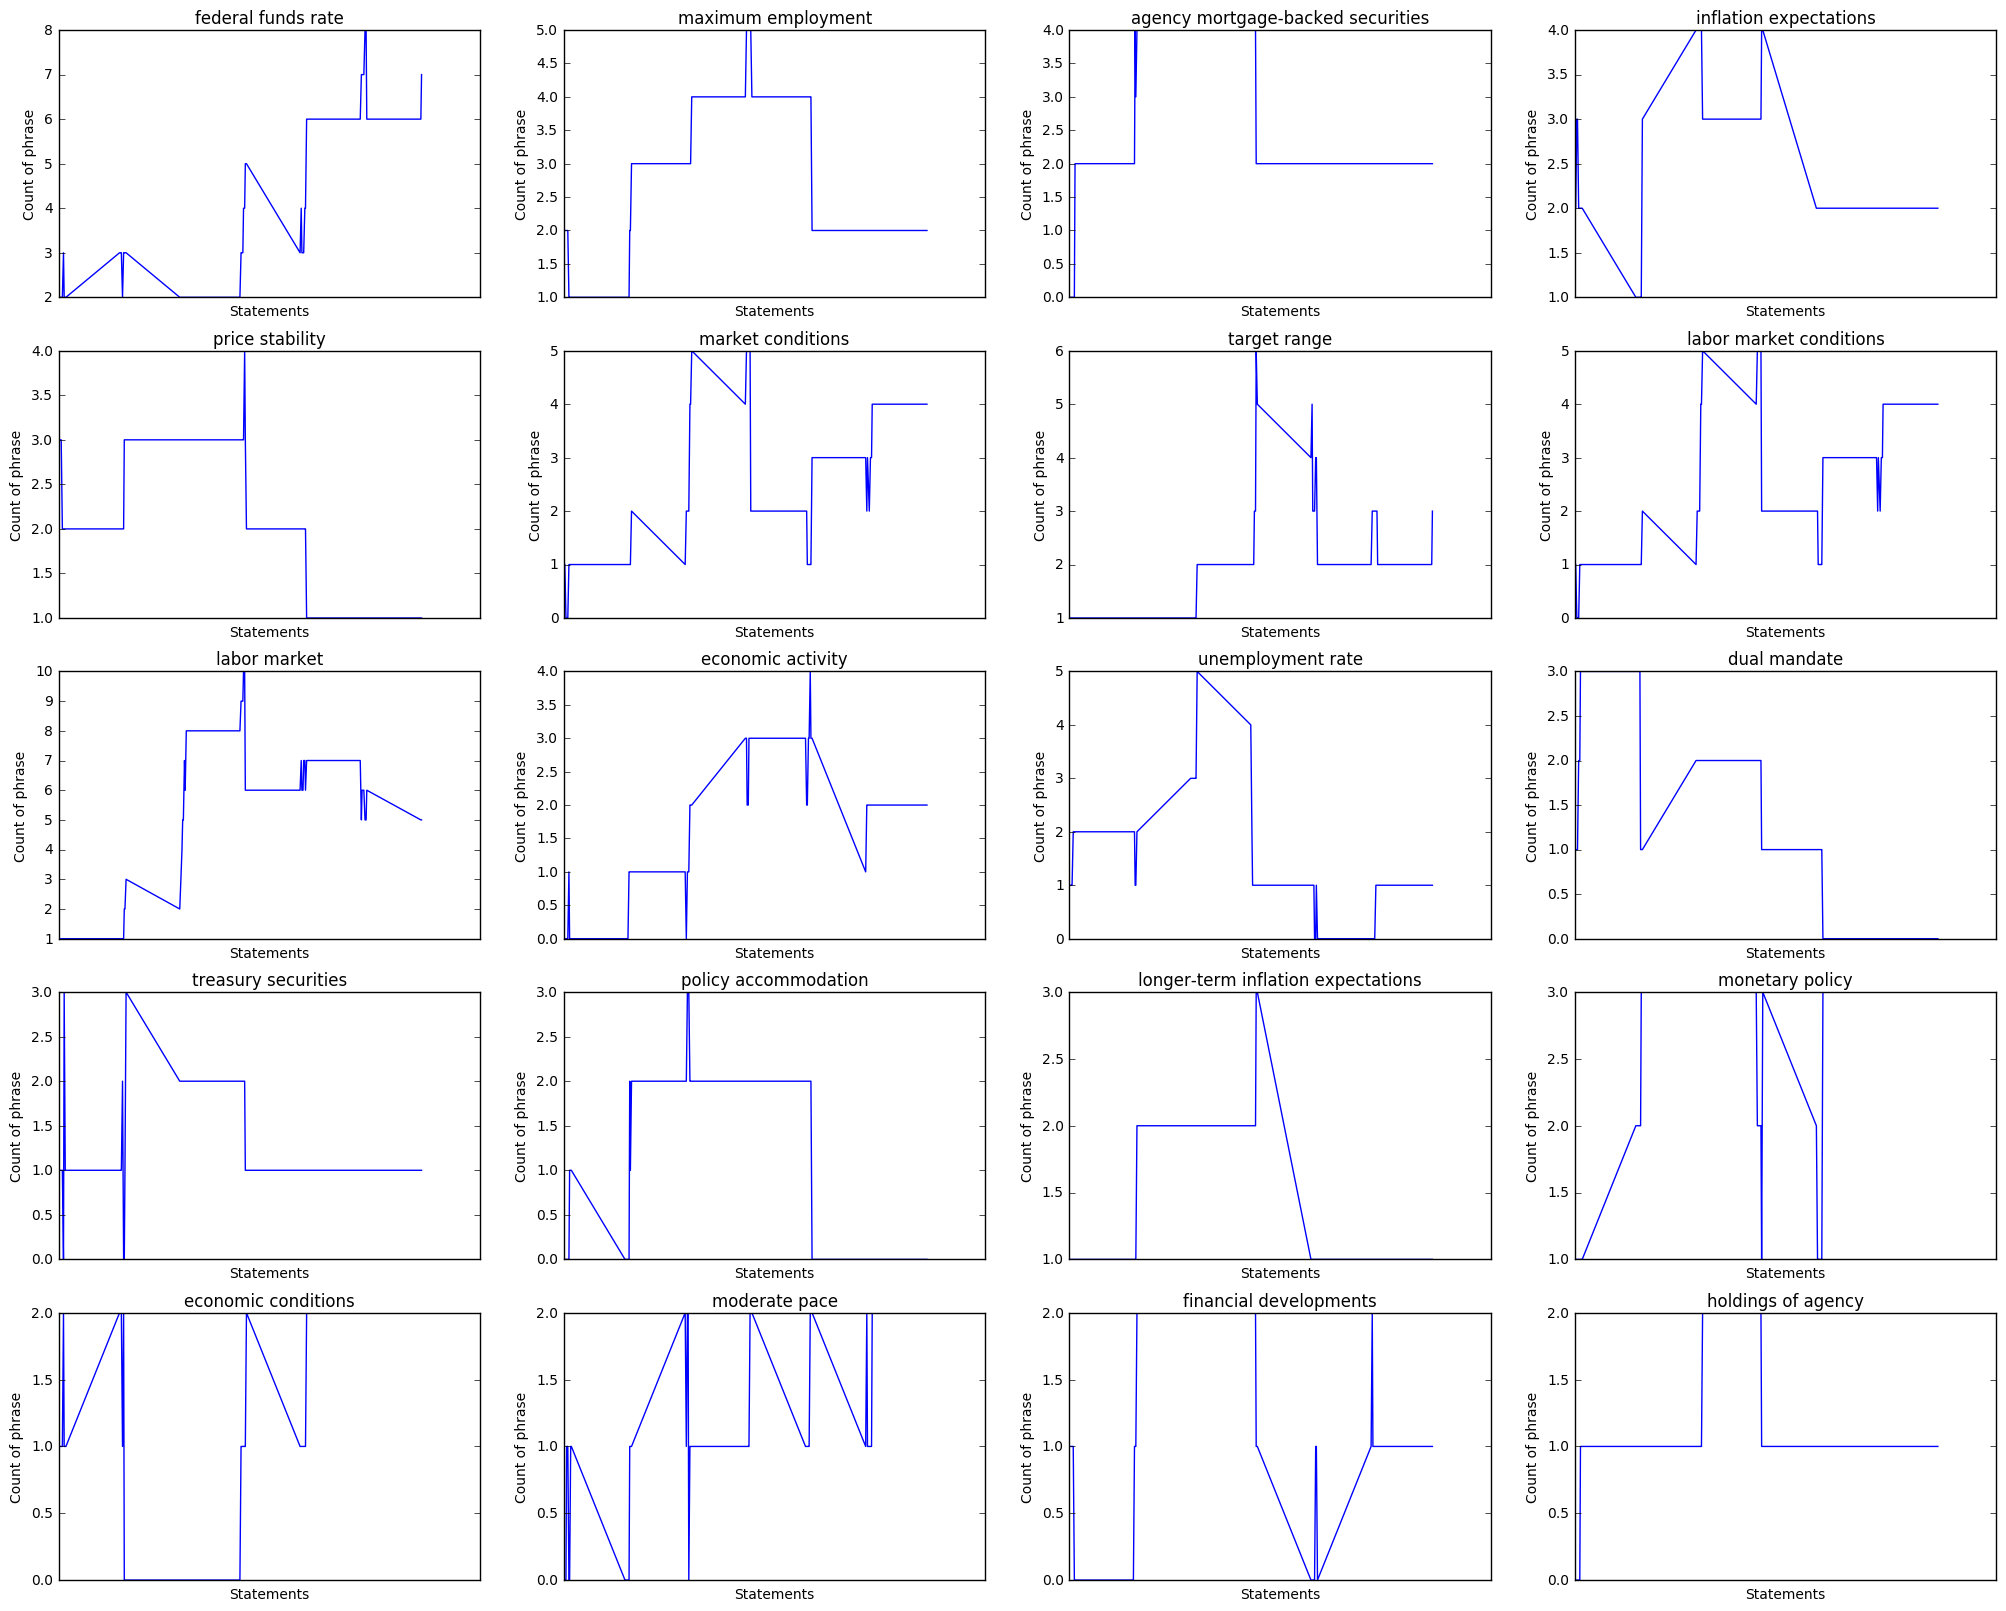

In [174]:
plt.figure(0, figsize=(25,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(df[phrases[i]])
    plt.xlabel("Statements")
    plt.ylabel("Count of phrase")
    plt.gca().get_xaxis().set_ticks([])
    plt.title(phrases[i])
plt.show()

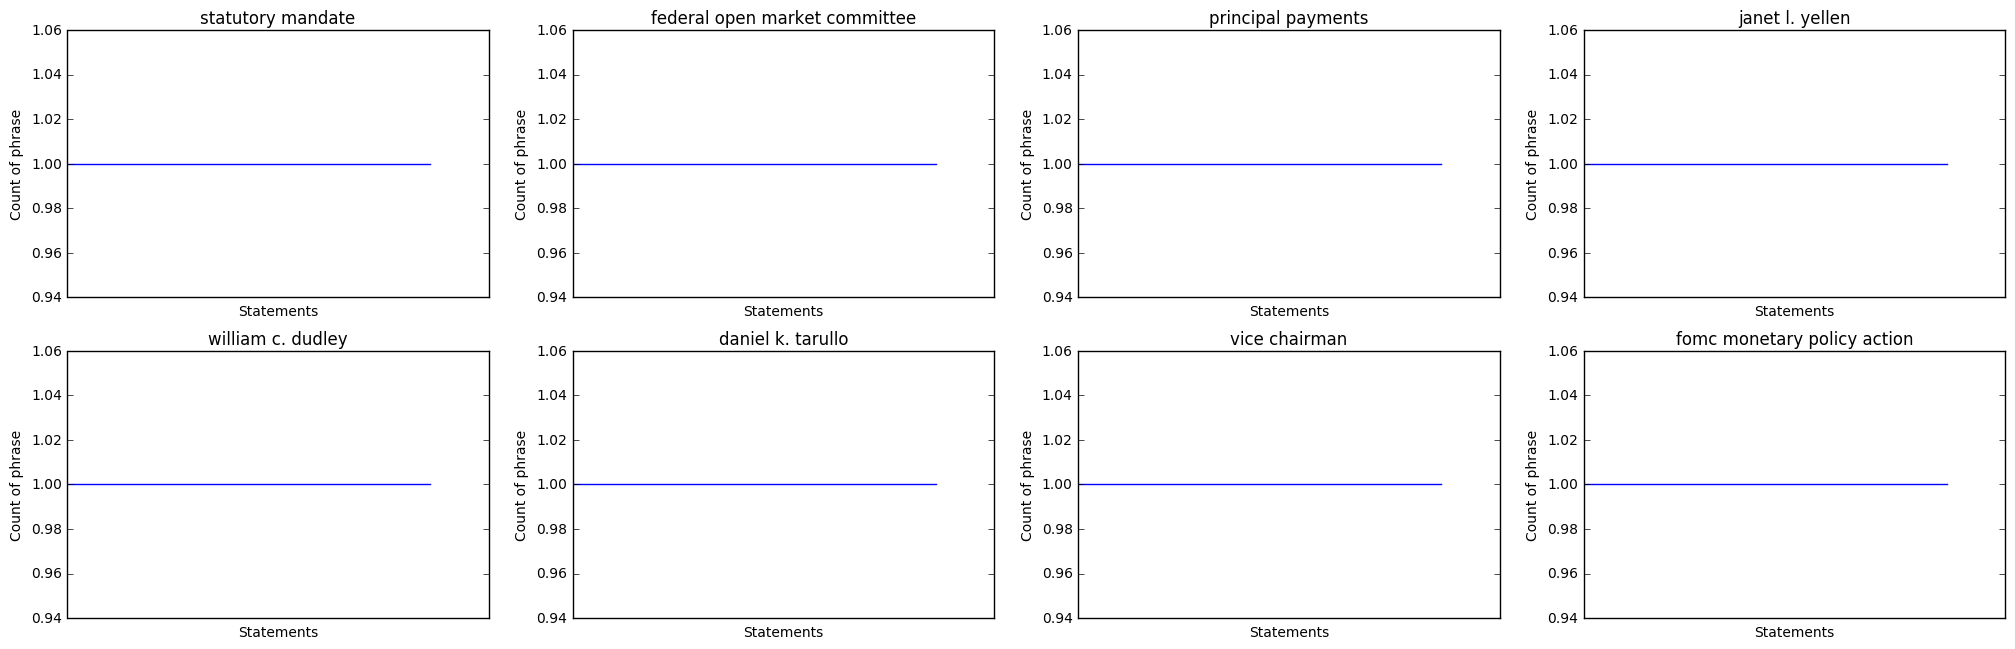

In [175]:
plt.figure(0, figsize=(25,20))
for i in range(20,len(phrases)):
    plt.subplot(5,4,i+1-20)
    plt.plot(df[phrases[i]])
    plt.xlabel("Statements")
    plt.ylabel("Count of phrase")
    plt.gca().get_xaxis().set_ticks([])
    
    plt.title(phrases[i])
plt.show()

In [182]:
STOP_WORDS=corpus.stopwords.words()
STOP_WORDS.append(",")
STOP_WORDS.append(".")
STOP_WORDS.append(";")
STOP_WORDS.append("$")
STOP_WORDS.append("0")
STOP_WORDS.append("1/2")
STOP_WORDS.append("1/4")
STOP_WORDS.append("2")
STOP_WORDS.append("40")
STOP_WORDS.append("6-1/2")
STOP_WORDS.append(":")
STOP_WORDS.append("a.")
STOP_WORDS.append("'s")
STOP_WORDS.append("--")
phrases_amended=[]
for phrase in phrases:
    phrase_amended=phrase.replace(" ","_")
    phrases_amended.append(phrase_amended)

In [193]:
statements=[]
for fileid in fed.fileids():
    statement=fed.raw(fileid)
    sentences=sent_tokenize(statement)
    for sentence in sentences:
        sentence_lower=sentence.lower()
        for i,val in enumerate(phrases):
            sentence_lower=sentence_lower.replace(phrases[i],phrases_amended[i])
        tokenized_sentence=word_tokenize(sentence_lower)
        pos_tokens=pos_tag(tokenized_sentence)
        
        #print(tokenized_sentence)
        clean_sentence=[]
        for item in pos_tokens:
            word=item[0]
            pos=penn_to_wn(item[1])
            #print(word,pos)
            if word.lower() not in STOP_WORDS:
                if pos is None:
                    clean_sentence.append(wordnet_lemmatizer.lemmatize(word.lower()))
                else:
                    clean_sentence.append(wordnet_lemmatizer.lemmatize(word.lower(),pos))
        statements.append(clean_sentence)
len(statements)

1030

In [194]:
statements[0:5]

[['information',
  'receive',
  'since',
  'federal_open_market_committee',
  'december',
  'confirms',
  'economic',
  'recovery',
  'continue',
  'though',
  'rate',
  'insufficient',
  'bring',
  'significant',
  'improvement',
  'labor_market_conditions'],
 ['growth',
  'household',
  'spending',
  'pick',
  'late',
  'last',
  'year',
  'remains',
  'constrain',
  'high',
  'unemployment',
  'modest',
  'income',
  'growth',
  'low',
  'housing',
  'wealth',
  'tight',
  'credit'],
 ['business',
  'spending',
  'equipment',
  'software',
  'rise',
  'investment',
  'nonresidential',
  'structure',
  'still',
  'weak'],
 ['employer', 'remain', 'reluctant', 'add', 'payroll'],
 ['housing', 'sector', 'continue', 'depress']]

In [210]:
model = word2vec.Word2Vec(statements, size=20, window=20, min_count=len(fed.fileids())*1.5, workers=4)
model.wv.vocab

{'accommodative': <gensim.models.keyedvectors.Vocab at 0x28904239780>,
 'action': <gensim.models.keyedvectors.Vocab at 0x28904239ba8>,
 'agency_mortgage-backed_securities': <gensim.models.keyedvectors.Vocab at 0x289041b1ef0>,
 'anticipate': <gensim.models.keyedvectors.Vocab at 0x28904239cc0>,
 'appropriate': <gensim.models.keyedvectors.Vocab at 0x28904239a58>,
 'committee': <gensim.models.keyedvectors.Vocab at 0x28903108f60>,
 'consistent': <gensim.models.keyedvectors.Vocab at 0x28904239710>,
 'continue': <gensim.models.keyedvectors.Vocab at 0x289042399b0>,
 'decide': <gensim.models.keyedvectors.Vocab at 0x28904239a20>,
 'decline': <gensim.models.keyedvectors.Vocab at 0x289042398d0>,
 'economic': <gensim.models.keyedvectors.Vocab at 0x289030a5da0>,
 'economic_activity': <gensim.models.keyedvectors.Vocab at 0x289030b2d68>,
 'expect': <gensim.models.keyedvectors.Vocab at 0x289042394e0>,
 'federal_funds_rate': <gensim.models.keyedvectors.Vocab at 0x289041abfd0>,
 'financial': <gensim.mode

In [211]:
model.wv['inflation']

array([-1.10126126,  0.41414818,  0.58926922,  0.04541207, -0.79492819,
        0.0762899 , -0.0551094 , -0.2546322 ,  0.18118747,  0.14591101,
        0.099741  ,  0.18315263, -0.54060233,  0.31320211,  0.03755588,
       -0.19580457,  0.82066363, -0.0782019 , -0.28936753,  0.01736294], dtype=float32)

In [212]:
model.most_similar('inflation')

[('longer-term', 0.9990987181663513),
 ('purchase', 0.998883843421936),
 ('accommodative', 0.9988819360733032),
 ('percent', 0.9988025426864624),
 ('low', 0.9987268447875977),
 ('toward', 0.998688280582428),
 ('unemployment_rate', 0.9986644387245178),
 ('committee', 0.9986615180969238),
 ('inflation_expectations', 0.9985589981079102),
 ('economic', 0.9984915256500244)]

In [213]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

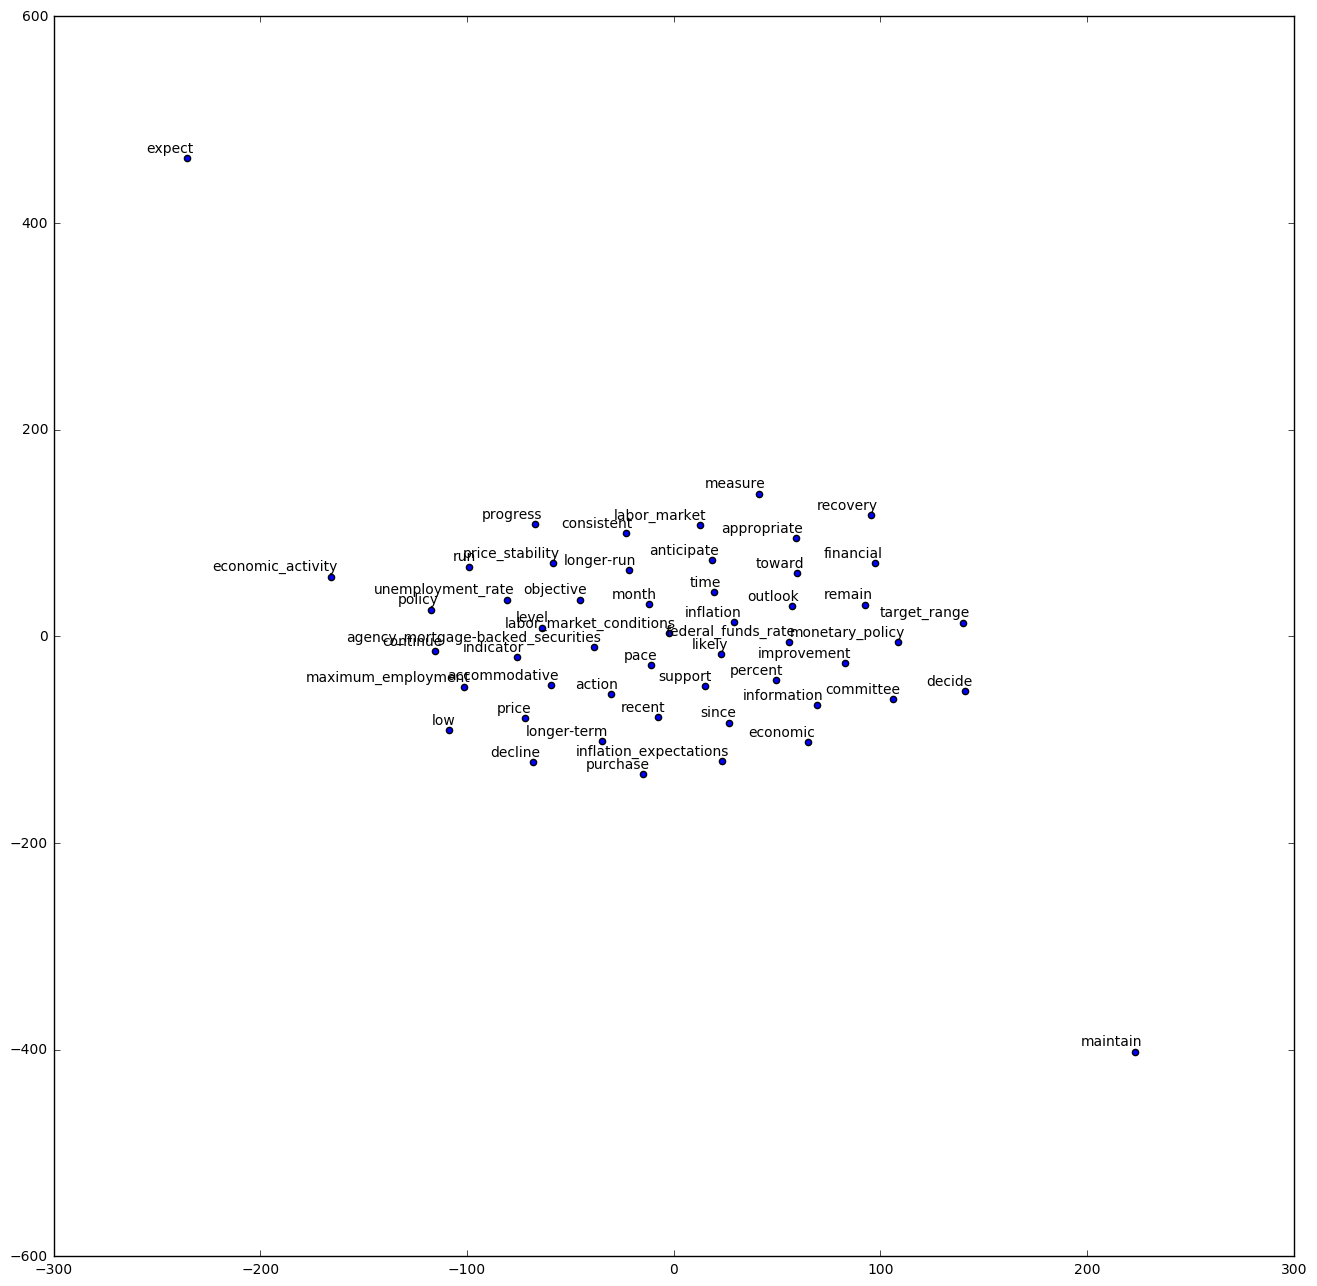

In [214]:
tsne_plot(model)

In [226]:
statements=[]
for fileid in fed.fileids():
    statement=fed.raw(fileid)
    sentences=sent_tokenize(statement)
    for sentence in sentences:
        sentence_lower=sentence.lower()
        tokenized_sentence=word_tokenize(sentence_lower)
        statements.append(tokenized_sentence)
print(len(statements))
bigram_transformer = Phrases(statements)
bigram = Phraser(phrases)

1030


NameError: name 'Phraser' is not defined

In [228]:
bigram_transformer